<a href="https://colab.research.google.com/github/JuanUnocc/Prediccion_Entregas_Retrasadas_Amazon/blob/main/Prediccion_Despachos_Retrasos_Entrega_AMAZON_JUAN_UNOCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# =====================================================
# 🎓 Advanced Machine Learning
# Tema: Predicción de retrasos en entrega (Amazon)
# Autor: J. Unocc
# Docente: C. Marino
# =====================================================

 ✅ Objetivo:
   Construir un modelo que prediga si un pedido se retrasará (is_delayed=1) o no (is_delayed=0)

 ✅ Flujo del notebook:
   1) Cargar datos (Google Drive)
   2) Limpieza básica (por si hay filas mal formateadas)
   3) EDA rápido
   4) Mapeo de columnas de fecha (evitar KeyError)
   5) Conversión de tipos (fechas / numéricos)
   6) Creación del Target (is_delayed)
   7) Feature Engineering (tiempo / logística)
   8) Selección de features (✅ CORREGIDO: evita KeyError ship_to_delivery_days)
   9) Train/Test split (preferible temporal)
  10) Preprocesamiento (numéricas + categóricas)
  11) Modelo baseline (Logistic Regression)
  12) Modelo principal (Random Forest)
  13) Comparación final + Matriz de confusión
  14) Detalles importantes para mi informe
# =====================================================


# =====================================================
# 0) LIBRERÍAS Y CONFIGURACIÓN
# =====================================================

In [9]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# =====================================================
# 1) CARGA DE DATOS (Google Drive)
# =====================================================


In [10]:
# Yo monto Drive porque mi archivo está en "Mi unidad"
drive.mount('/content/drive')

# Ruta del archivo (según tu Drive)
FILE_PATH = "/content/drive/MyDrive/amazon_data.csv"

# Yo cargo el dataset
df_raw = pd.read_csv(FILE_PATH)

print("✅ Dataset cargado (raw)")
print("Shape:", df_raw.shape)
display(df_raw.head())

print("\n🧾 Columnas disponibles:")
print(df_raw.columns.tolist())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset cargado (raw)
Shape: (10000, 21)


,order_id,order_date,ship_date,delivery_date,order_status,customer_id,customer_name,country,state,city,...,product_name,category,sub_category,brand,quantity,unit_price,discount,shipping_cost,total_sales,payment_method
0,A10000,2026-01-31,2026-01-31,2026-01-08,Delivered,C5691,Ricky Potter,India,South Carolina,New Joe,...,without,Home,Furniture,Doyle-Jordan,3.0,42467.79,0.26,60.85,94339.3438,Card
1,A10001,2026-01-20,2026-02-03,2026-02-03,Delivered,C9811,Chris Davenport,India,Tennessee,Madisonmouth,...,school,Home,Furniture,Davis LLC,2.0,36138.76,0.24,112.96,55043.8752,COD
2,A10002,2026-01-15,2026-02-07,2026-01-03,Delivered,C7341,Timothy Gallagher,India,Iowa,East Larryberg,...,I,Electronics,Laptop,Watson and Sons,4.0,47148.93,0.14,64.11,162256.4292,UPI
3,"A10003,2026-01-18,2026-01-15,2026-01-20,Delive...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"A10004,2026-01-27,2026-01-04,2026-01-23,Delive...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🧾 Columnas disponibles:
['order_id', 'order_date', 'ship_date', 'delivery_date', 'order_status', 'customer_id', 'customer_name', 'country', 'state', 'city', 'product_id', 'product_name', 'category', 'sub_category', 'brand', 'quantity', 'unit_price', 'discount', 'shipping_cost', 'total_sales', 'payment_method']


# =====================================================
# 2) LIMPIEZA BÁSICA (por si existen filas mal parseadas)
# =====================================================
"""
A veces un CSV llega con filas “pegadas” (toda la fila se mete en una sola columna).
Yo hago una validación rápida y si detecto ese patrón, reconstruyo esas filas.
Si no lo detecto, continúo normal.
"""


In [11]:
df = df_raw.copy()

first_col = df.columns[0]

# Si una fila tiene demasiadas comas en la primera columna y el resto tiene muchos NaN, es sospechosa
mask_suspicious = df[first_col].astype(str).str.count(",") >= (len(df.columns) - 1)
mask_many_nans = df.isna().sum(axis=1) >= int(len(df.columns) * 0.7)
mask_bad = mask_suspicious & mask_many_nans

bad_count = int(mask_bad.sum())

if bad_count > 0:
    print(f"\n⚠️ Detecté {bad_count} filas mal formateadas. Procedo a reconstruirlas...")
    EXPECTED_COLS = df.columns.tolist()
    N_COLS = len(EXPECTED_COLS)

    rebuilt_rows = []
    for s in df.loc[mask_bad, first_col].astype(str):
        parts = [p.strip() for p in s.split(",")]
        if len(parts) == N_COLS:
            rebuilt_rows.append(parts)

    df_rebuilt = pd.DataFrame(rebuilt_rows, columns=EXPECTED_COLS)
    df_good = df.loc[~mask_bad].copy()

    df = pd.concat([df_good, df_rebuilt], ignore_index=True)
    print("✅ Reconstrucción completada.")
else:
    print("\n✅ No detecté filas pegadas. Continúo con el dataset tal cual.")

print("\n📌 Shape final (limpio):", df.shape)
display(df.head())



⚠️ Detecté 3432 filas mal formateadas. Procedo a reconstruirlas...
✅ Reconstrucción completada.

📌 Shape final (limpio): (6568, 21)


/tmp/ipython-input-1001603654.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_good, df_rebuilt], ignore_index=True)


,order_id,order_date,ship_date,delivery_date,order_status,customer_id,customer_name,country,state,city,...,product_name,category,sub_category,brand,quantity,unit_price,discount,shipping_cost,total_sales,payment_method
0,A10000,2026-01-31,2026-01-31,2026-01-08,Delivered,C5691,Ricky Potter,India,South Carolina,New Joe,...,without,Home,Furniture,Doyle-Jordan,3.0,42467.79,0.26,60.85,94339.3438,Card
1,A10001,2026-01-20,2026-02-03,2026-02-03,Delivered,C9811,Chris Davenport,India,Tennessee,Madisonmouth,...,school,Home,Furniture,Davis LLC,2.0,36138.76,0.24,112.96,55043.8752,COD
2,A10002,2026-01-15,2026-02-07,2026-01-03,Delivered,C7341,Timothy Gallagher,India,Iowa,East Larryberg,...,I,Electronics,Laptop,Watson and Sons,4.0,47148.93,0.14,64.11,162256.4292,UPI
3,A10005,2026-01-05,2026-01-12,2026-01-11,Delivered,C9019,Lauren Russell,India,South Carolina,Ryanburgh,...,through,Home,Furniture,Lee Inc,3.0,12618.95,0.22,105.47,29633.8130,Card
4,A10006,2026-01-04,2026-01-10,2026-01-21,Delivered,C9866,Heather Campos,India,Colorado,Turnerville,...,page,Electronics,Mobile,Wade-Jackson,4.0,41577.60,0.06,29.90,156361.6760,COD


# =====================================================
# 3) EDA RÁPIDO (para entender qué tengo)
# =====================================================


In [12]:
print("\n📋 Información del Dataset:")
df.info()

print("\n📈 Estadísticas descriptivas (numéricas):")
display(df.describe(include=[np.number]))

print("\n📌 Frecuencias (categóricas - top 5):")
cat_cols_preview = df.select_dtypes(include=["object", "category"]).columns[:8]

if len(cat_cols_preview) == 0:
    print("⚠️ No se encontraron columnas categóricas.")
else:
    for c in cat_cols_preview:
        print(f"\n🔹 Columna: {c}")
        display(df[c].value_counts().head(5))



📋 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        6568 non-null   object 
 1   order_date      6568 non-null   object 
 2   ship_date       6568 non-null   object 
 3   delivery_date   6568 non-null   object 
 4   order_status    6568 non-null   object 
 5   customer_id     6568 non-null   object 
 6   customer_name   6568 non-null   object 
 7   country         6568 non-null   object 
 8   state           6568 non-null   object 
 9   city            6568 non-null   object 
 10  product_id      6568 non-null   object 
 11  product_name    6568 non-null   object 
 12  category        6568 non-null   object 
 13  sub_category    6568 non-null   object 
 14  brand           6568 non-null   object 
 15  quantity        6568 non-null   float64
 16  unit_price      6568 non-null   float64
 17  disco

,quantity,unit_price,discount,shipping_cost,total_sales
count,6568.000000,6568.000000,6568.000000,6568.000000,6568.000000
mean,2.992083,25200.576443,0.150941,85.096698,63957.058301
std,1.421066,14338.664218,0.086651,37.649077,50752.822321
min,1.000000,214.200000,0.000000,20.010000,309.939600
25%,2.000000,12802.592500,0.080000,52.632500,23709.420725
50%,3.000000,24994.955000,0.150000,85.140000,50081.843800
75%,4.000000,37634.322500,0.230000,117.735000,93702.295500
max,5.000000,49980.910000,0.300000,149.920000,249155.530000



📌 Frecuencias (categóricas - top 5):

🔹 Columna: order_id


,count
order_id,
A19996,1
A10000,1
A10001,1
A10002,1
A10005,1



🔹 Columna: order_date


,count
order_date,
2026-01-08,189
2026-01-25,187
2026-01-12,181
2026-01-14,181
2026-02-06,176



🔹 Columna: ship_date


,count
ship_date,
2026-01-30,198
2026-01-15,191
2026-01-06,183
2026-02-02,182
2026-01-12,177



🔹 Columna: delivery_date


,count
delivery_date,
2026-01-18,189
2026-01-16,181
2026-01-10,178
2026-01-20,176
2026-02-03,175



🔹 Columna: order_status


,count
order_status,
Delivered,6568



🔹 Columna: customer_id


,count
customer_id,
C1076,6
C3217,6
C7607,6
C1476,5
C7646,5



🔹 Columna: customer_name


,count
customer_name,
David White,5
William Smith,5
Christopher Smith,4
John Smith,4
Michael Brown,4



🔹 Columna: country


,count
country,
India,6568


# =====================================================
# 4) MAPEO AUTOMÁTICO DE COLUMNAS (evitar KeyError)
# =====================================================
"""
Como los datasets pueden variar en nombres, yo hago un mapeo automático.
Esto me evita errores tipo KeyError: 'delivered_date'.
"""


In [13]:
cols_lower = {c: str(c).lower().strip() for c in df.columns}

def find_col(keywords):
    """Yo busco la primera columna que contenga alguno de los keywords."""
    for original, low in cols_lower.items():
        if any(k in low for k in keywords):
            return original
    return None

# Fechas típicas
COL_ORDER_DATE     = find_col(["order_date", "order date", "purchase", "created"])
COL_SHIP_DATE      = find_col(["ship_date", "ship date", "shipped"])
COL_DELIVERED_DATE = find_col(["delivery_date", "delivered_date", "delivered", "actual_delivery", "received"])

# Fecha prometida/estimada (si existe)
COL_PROMISED_DATE  = find_col(["promised", "estimated", "expected", "eta", "promise", "est_delivery", "estimated_delivery"])

print("\n✅ Columnas detectadas (propuesta):")
print("COL_ORDER_DATE     :", COL_ORDER_DATE)
print("COL_SHIP_DATE      :", COL_SHIP_DATE)
print("COL_PROMISED_DATE  :", COL_PROMISED_DATE)
print("COL_DELIVERED_DATE :", COL_DELIVERED_DATE)



✅ Columnas detectadas (propuesta):
COL_ORDER_DATE     : order_date
COL_SHIP_DATE      : ship_date
COL_PROMISED_DATE  : None
COL_DELIVERED_DATE : delivery_date


# =====================================================
# 5) CONVERSIÓN DE TIPOS (fechas y numéricos)
# =====================================================


In [14]:
# Yo convierto a datetime sólo si existen
for col in [COL_ORDER_DATE, COL_SHIP_DATE, COL_PROMISED_DATE, COL_DELIVERED_DATE]:
    if col is not None and col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Yo intento convertir columnas numéricas comunes (si existen)
possible_numeric = ["quantity", "unit_price", "discount", "shipping_cost", "total_sales", "price", "amount", "cost", "distance", "weight"]
for c in df.columns:
    low = cols_lower.get(c, "")
    if any(k in low for k in possible_numeric):
        df[c] = pd.to_numeric(df[c], errors="coerce")


# =====================================================
# 6) CREACIÓN DEL TARGET (is_delayed)
# =====================================================
"""
Aquí yo creo mi variable objetivo de retraso.

✅ Caso A (ideal): tengo fecha prometida/estimada y fecha real -> delayed = real > prometida
✅ Caso B (cuando NO hay prometida): uso un umbral de días desde ship_date a delivered_date

Nota importante:
- Yo no puedo usar delivery_date como predictor después (eso sería fuga de información).
"""



✅ Target creado usando umbral de días (Caso B). Umbral = 7 días

📌 Distribución del target:
is_delayed
0    4339
1    2229
Name: count, dtype: int64
is_delayed
0    0.660627
1    0.339373
Name: ratio, dtype: float64


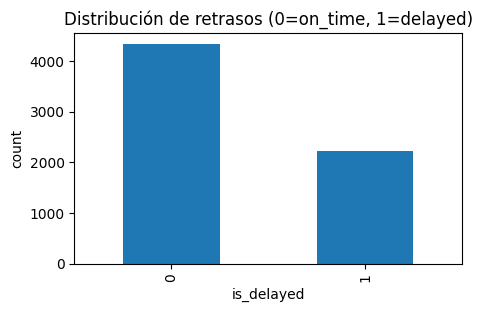

In [15]:

TARGET_COLUMN = "is_delayed"

# Validación mínima: debo tener fecha real de entrega
if COL_DELIVERED_DATE is None or COL_DELIVERED_DATE not in df.columns:
    raise ValueError("❌ No encuentro una columna de entrega real (delivery/delivered). Revisa df.columns.")

# Caso A: existe fecha prometida/estimada
if COL_PROMISED_DATE is not None and COL_PROMISED_DATE in df.columns:
    df[COL_PROMISED_DATE]  = pd.to_datetime(df[COL_PROMISED_DATE], errors="coerce")
    df[COL_DELIVERED_DATE] = pd.to_datetime(df[COL_DELIVERED_DATE], errors="coerce")

    df[TARGET_COLUMN] = (df[COL_DELIVERED_DATE] > df[COL_PROMISED_DATE]).astype("float")
    df = df.dropna(subset=[TARGET_COLUMN]).copy()
    df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(int)

    print("\n✅ Target creado usando PROMISED/ESTIMATED vs DELIVERED (Caso A).")

else:
    # Caso B: no tengo prometida, uso ship_date + umbral
    if COL_SHIP_DATE is None or COL_SHIP_DATE not in df.columns:
        raise ValueError("❌ No hay promised_date y tampoco encuentro ship_date. Necesito ship_date y delivery_date.")

    df[COL_SHIP_DATE]      = pd.to_datetime(df[COL_SHIP_DATE], errors="coerce")
    df[COL_DELIVERED_DATE] = pd.to_datetime(df[COL_DELIVERED_DATE], errors="coerce")

    df["ship_to_delivery_days"] = (df[COL_DELIVERED_DATE] - df[COL_SHIP_DATE]).dt.days
    df = df.dropna(subset=["ship_to_delivery_days"]).copy()

    THRESHOLD_DAYS = 7  # 👈 Yo ajusto este umbral según el negocio (ej: SLA de 7 días)
    df[TARGET_COLUMN] = (df["ship_to_delivery_days"] > THRESHOLD_DAYS).astype(int)

    print(f"\n✅ Target creado usando umbral de días (Caso B). Umbral = {THRESHOLD_DAYS} días")

# Distribución del target
print("\n📌 Distribución del target:")
print(df[TARGET_COLUMN].value_counts())
print(df[TARGET_COLUMN].value_counts(normalize=True).rename("ratio"))

plt.figure(figsize=(5,3))
df[TARGET_COLUMN].value_counts().plot(kind="bar")
plt.title("Distribución de retrasos (0=on_time, 1=delayed)")
plt.xlabel(TARGET_COLUMN)
plt.ylabel("count")
plt.show()


# =====================================================
# 7) FEATURE ENGINEERING (sin fuga de información)
# =====================================================
"""
Aquí yo creo variables derivadas del tiempo.
Importante: NO uso delivery_date como feature (leakage).
"""


In [16]:
# Features desde order_date
if COL_ORDER_DATE is not None and COL_ORDER_DATE in df.columns:
    df["order_year"]  = df[COL_ORDER_DATE].dt.year
    df["order_month"] = df[COL_ORDER_DATE].dt.month
    df["order_day"]   = df[COL_ORDER_DATE].dt.day
    df["order_dow"]   = df[COL_ORDER_DATE].dt.dayofweek

# Features desde ship_date
if COL_SHIP_DATE is not None and COL_SHIP_DATE in df.columns:
    df["ship_year"]  = df[COL_SHIP_DATE].dt.year
    df["ship_month"] = df[COL_SHIP_DATE].dt.month
    df["ship_dow"]   = df[COL_SHIP_DATE].dt.dayofweek

# Lead time (order -> ship)
if (COL_ORDER_DATE is not None and COL_SHIP_DATE is not None and
    COL_ORDER_DATE in df.columns and COL_SHIP_DATE in df.columns):
    df["order_to_ship_days"] = (df[COL_SHIP_DATE] - df[COL_ORDER_DATE]).dt.days


# =====================================================
# 8) SELECCIÓN DE FEATURES (✅ CORREGIDO: evita KeyError)
# =====================================================
"""
En esta sección yo construyo X e y.

✅ Corrección aplicada:
- Vuelvo a construir cols_lower DESPUÉS de que df cambió (porque ya creé columnas nuevas).
- Uso cols_lower.get(...) para evitar KeyError.
- Sólo excluyo ship_to_delivery_days si existe realmente.
"""


In [17]:
# ✅ Recalculo cols_lower porque df ya cambió (tiene columnas nuevas)
cols_lower = {c: str(c).lower().strip() for c in df.columns}

# Columnas que debo excluir (leakage)
drop_cols = set([TARGET_COLUMN])

# No usar fecha real de entrega
if COL_DELIVERED_DATE is not None and COL_DELIVERED_DATE in df.columns:
    drop_cols.add(COL_DELIVERED_DATE)

# No usar promised_date si existe
if COL_PROMISED_DATE is not None and COL_PROMISED_DATE in df.columns:
    drop_cols.add(COL_PROMISED_DATE)

# No usar ship_to_delivery_days si existe
if "ship_to_delivery_days" in df.columns:
    drop_cols.add("ship_to_delivery_days")

# (Opcional) Si me causan problemas las fechas crudas, las saco y me quedo con las derivadas.
# En general, yo recomiendo dejarlas fuera para evitar datetime en el modelo.
if COL_ORDER_DATE is not None and COL_ORDER_DATE in df.columns:
    drop_cols.add(COL_ORDER_DATE)
if COL_SHIP_DATE is not None and COL_SHIP_DATE in df.columns:
    drop_cols.add(COL_SHIP_DATE)

# Identifico columnas tipo ID sin causar errores
id_like = []
for c in df.columns:
    low = cols_lower.get(c, "")  # ✅ .get evita KeyError
    if any(k in low for k in ["order_id", "customer_id", "tracking", "invoice"]) or low.endswith("_id"):
        id_like.append(c)

drop_cols.update(id_like)

# Features finales
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].copy()
y = df[TARGET_COLUMN].copy()

print("\n✅ Columnas excluidas:", len(drop_cols))
print("✅ Features finales:", X.shape)
print("✅ Target:", y.shape)



✅ Columnas excluidas: 8
✅ Features finales: (6568, 23)
✅ Target: (6568,)



# =====================================================
# 9) TRAIN / TEST SPLIT (temporal si tengo order_date)
# =====================================================
"""
Si tengo order_date, yo separo por tiempo (más realista):
- Entreno con el pasado y pruebo con el futuro.
"""


In [18]:
# Si tengo order_date, hago split temporal
USE_TIME_SPLIT = (COL_ORDER_DATE is not None and COL_ORDER_DATE in df.columns)

if USE_TIME_SPLIT:
    df_sorted = df.sort_values(COL_ORDER_DATE).reset_index(drop=True)
    X = df_sorted[feature_cols].copy()
    y = df_sorted[TARGET_COLUMN].copy()

    split_idx = int(len(df_sorted) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    print("\n✅ Time split aplicado (80/20)")

else:
    # Si no hay fecha, hago split estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )
    print("\n✅ Random split estratificado aplicado (80/20)")

print("Train:", X_train.shape, "Test:", X_test.shape)



✅ Time split aplicado (80/20)
Train: (5254, 23) Test: (1314, 23)


# =====================================================
# 10) PREPROCESAMIENTO (numéricas + categóricas)
# =====================================================


In [19]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\n🔢 Numéricas:", len(numeric_features))
print("🔤 Categóricas:", len(categorical_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)



🔢 Numéricas: 13
🔤 Categóricas: 10


# =====================================================
# 11) MODELO BASELINE (Logistic Regression)
# =====================================================


In [20]:
baseline_model = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_SEED,
    class_weight="balanced"
)

baseline_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", baseline_model)
])

baseline_pipe.fit(X_train, y_train)

y_pred_base = baseline_pipe.predict(X_test)
y_proba_base = baseline_pipe.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("📌 BASELINE - Logistic Regression")
print("="*60)
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_base, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_base, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_base))



📌 BASELINE - Logistic Regression
Accuracy : 0.5981735159817352
Precision: 0.453305351521511
Recall   : 0.9840546697038725
F1       : 0.6206896551724138
ROC-AUC  : 0.8277826228441262


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# =====================================================
# 12) MODELO 2 (Random Forest)
# =====================================================



🌳 RANDOM FOREST
Accuracy : 0.6301369863013698
Precision: 0.47123623011015914
Recall   : 0.876993166287016
F1       : 0.6130573248407644
ROC-AUC  : 0.7416752359258054

📋 Reporte de clasificación (RF):

              precision    recall  f1-score   support

           0       0.89      0.51      0.65       875
           1       0.47      0.88      0.61       439

    accuracy                           0.63      1314
   macro avg       0.68      0.69      0.63      1314
weighted avg       0.75      0.63      0.63      1314


Matriz de confusión (RF):
 [[443 432]
 [ 54 385]]


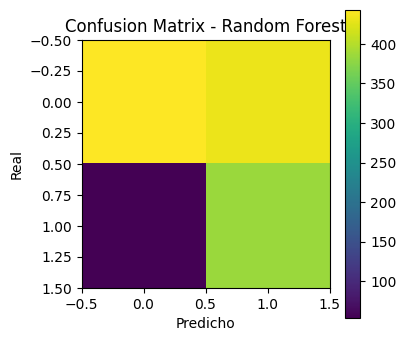

In [21]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf_model)
])

rf_pipe.fit(X_train, y_train)

y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("🌳 RANDOM FOREST")
print("="*60)
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_rf))

print("\n📋 Reporte de clasificación (RF):\n")
print(classification_report(y_test, y_pred_rf, zero_division=0))

cm = confusion_matrix(y_test, y_pred_rf)
print("\nMatriz de confusión (RF):\n", cm)

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.colorbar()
plt.show()


# =====================================================
# 13) COMPARACIÓN FINAL
# =====================================================


In [22]:

results = pd.DataFrame([
    {
        "Modelo": "Logistic Regression (Baseline)",
        "Accuracy": accuracy_score(y_test, y_pred_base),
        "Precision": precision_score(y_test, y_pred_base, zero_division=0),
        "Recall": recall_score(y_test, y_pred_base, zero_division=0),
        "F1": f1_score(y_test, y_pred_base, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba_base),
    },
    {
        "Modelo": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf, zero_division=0),
        "Recall": recall_score(y_test, y_pred_rf, zero_division=0),
        "F1": f1_score(y_test, y_pred_rf, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba_rf),
    }
]).sort_values("ROC_AUC", ascending=False)

print("\n" + "="*60)
print("📊 COMPARACIÓN FINAL DE MODELOS")
print("="*60)
display(results)



📊 COMPARACIÓN FINAL DE MODELOS


,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression (Baseline),0.598174,0.453305,0.984055,0.620690,0.827783
1,Random Forest,0.630137,0.471236,0.876993,0.613057,0.741675


# =====================================================
# 14) DETALLES IMPORTANTES (para el informe)
# =====================================================


In [23]:


print("\n" + "="*60)
print("🧠 DETALLES IMPORTANTES A CONSIDERAR (para mi informe)")
print("="*60)

print("""
1) Si mi dataset NO trae una fecha prometida/estimada, yo definí el retraso por un UMBRAL de días.
   - Esto lo debo justificar (ej: SLA típico de 7 días, política de entrega, percentiles, etc.).

2) Yo cuidé el DATA LEAKAGE:
   - No uso delivery_date ni ship_to_delivery_days como variables predictoras, porque contienen información futura.

3) Yo hice un SPLIT TEMPORAL si tuve order_date:
   - Entrené con el pasado y probé con el futuro para que el resultado sea más realista.

4) Si mi target está desbalanceado, Accuracy puede engañar:
   - En ese caso, yo me enfoco más en Recall/F1/ROC-AUC y uso class_weight='balanced'.

5) Mejora futura:
   - Probar otros modelos (Gradient Boosting / XGBoost), tuning de hiperparámetros y SHAP para interpretabilidad.
""")



🧠 DETALLES IMPORTANTES A CONSIDERAR (para mi informe)

1) Si mi dataset NO trae una fecha prometida/estimada, yo definí el retraso por un UMBRAL de días.
   - Esto lo debo justificar (ej: SLA típico de 7 días, política de entrega, percentiles, etc.).

2) Yo cuidé el DATA LEAKAGE:
   - No uso delivery_date ni ship_to_delivery_days como variables predictoras, porque contienen información futura.

3) Yo hice un SPLIT TEMPORAL si tuve order_date:
   - Entrené con el pasado y probé con el futuro para que el resultado sea más realista.

4) Si mi target está desbalanceado, Accuracy puede engañar:
   - En ese caso, yo me enfoco más en Recall/F1/ROC-AUC y uso class_weight='balanced'.

5) Mejora futura:
   - Probar otros modelos (Gradient Boosting / XGBoost), tuning de hiperparámetros y SHAP para interpretabilidad.

